<a href="https://colab.research.google.com/github/stellazhangsy/Amazon-Review-NLP/blob/master/COLAB12%E9%A2%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Q3 For each user, create a variable to indicate their spending behavior profile.  

In [0]:
# join Venmo original dataset with the dataset from question 1 that has description classification
# consider the transaction direction: only keep transactions that type is 'payment'
df_full = spark.sql("select user1, user2, t1.description, class, datetime \
                    from df_class t1 join Venmo t2 using (index) \
                    where transaction_type = 'payment' \
                    order by user1 ")
df_full.createOrReplaceTempView("df_full")
#df_full.show(4)

In [0]:
# For each user, calculate the number of his/her transactions per class and how many percents of total spendings 
df_profile = spark.sql("select user1, class, count(*) as transactions_per_class, \
                    concat(round(count(*)/sum(count(*)) over (partition by user1) *100, 2),'%') as ratio \
               from df_full \
               group by user1, class \
               order by user1")
#df_profile.show()

In [0]:
# create a list with unique classes 
categories = sorted(df_profile.select("class").distinct().rdd.map(lambda row: row[0]).collect())

cols = [when(col("class") == category, col("ratio")).otherwise(None).alias(category) 
    for category in categories]

maxs = [max(col(category)).alias(category) for category in categories]

# create static spending profile for each user
static_profile = (df_profile.select(col("user1"), *cols).groupBy("user1").agg(*maxs).na.fill(0))

static_profile.createOrReplaceTempView("static_profile")
#static_profile.show()

In [0]:
# df_profile = df_profile.withColumn("dict", concat(col("ratio"), lit(" "), col("class")))
# df_profile = df_profile.groupby("user1").agg(F.concat_ws(", ", 
#                                     F.collect_list(df_profile.dict)).alias("static_profile"))
# df_profile.registerTempTable("df_profile")
# df_profile.show(10, truncate = False)

+-----+---------------------------------------------------------------------------------------------------------+
|user1|static_profile                                                                                           |
+-----+---------------------------------------------------------------------------------------------------------+
|2    |100.0%people                                                                                             |
|3    |16.67%no_class, 50.0%people, 16.67%travel, 16.67%food                                                    |
|4    |16.67%illegal_sarcasm, 16.67%food, 33.33%people, 16.67%activity, 16.67%no_class                          |
|10   |10.0%no_class, 30.0%people, 10.0%activity, 50.0%food                                                     |
|11   |4.0%activity, 36.0%people, 4.0%illegal_sarcasm, 20.0%no_class, 20.0%food, 8.0%travel, 8.0%utility        |
|12   |33.33%people, 11.11%activity, 33.33%no_class, 11.11%food, 11.11%illegal_sarcasm  

## Q4 For each user, create a dynamic spending profile (12 months)

In [0]:
# navigate the first transaction date and only keep first 12 months transactions for each user 
days_tbl = spark.sql("select user1, user2, datetime, class, datediff(datetime, \
                first_value(datetime) over (partition by user1 order by datetime)) as days \
                from df_full \
                group by user1, user2, datetime, class\
                order by user1")
#days_tbl.show()

In [0]:
# add lifetime indiactor (0-12 where 0 represents the 1st transaction and 1 represents 1 month and so on)
days_lifeindicator_tbl = days_tbl.select("*", 
            when(days_tbl.days==0, 0)\
         .when((days_tbl.days>0) & (days_tbl.days<=30), 1) \
         .when((days_tbl.days>30) & (days_tbl.days<=60), 2) \
         .when((days_tbl.days>60) & (days_tbl.days<=90), 3)\
         .when((days_tbl.days>90) & (days_tbl.days<=120), 4)\
         .when((days_tbl.days>120) & (days_tbl.days<=150), 5)\
         .when((days_tbl.days>150) & (days_tbl.days<=180), 6)\
         .when((days_tbl.days>180) & (days_tbl.days<=210), 7)\
         .when((days_tbl.days>210) & (days_tbl.days<=240), 8)\
         .when((days_tbl.days>240) & (days_tbl.days<=270), 9)\
         .when((days_tbl.days>270) & (days_tbl.days<=300), 10)\
         .when((days_tbl.days>300) & (days_tbl.days<=330), 11)\
         .when((days_tbl.days>330) & (days_tbl.days<=360), 12)\
         .otherwise(-1).alias('lifetime_indicator'))
days_lifeindicator_tbl.createOrReplaceTempView("days_lifeindicator_tbl")

# filter out records where "datetime-startdate">=360 days (12 months after first transaction)
lifetime_tbl = days_lifeindicator_tbl.filter("lifetime_indicator != -1 ").sort("user1")

#lifetime_tbl.show()

In [0]:
lifetime_tbl = lifetime_tbl\
        .withColumn("lifetime_category", 
                        concat(lit("time"), col("lifetime_indicator"), lit("_"), col("class")))\
        .withColumn("user_life", concat(col("user1"), lit("_"), col("lifetime_indicator")))

lifetime_tbl.createOrReplaceTempView("lifetime_tbl")

dynamic_tbl = spark.sql("select user1, lifetime_indicator, class, \
                round(count(*)/sum(count(*)) \
                  over (partition by user1, lifetime_indicator), 2) as percentage \
               from lifetime_tbl \
               group by user1, lifetime_indicator, class \
               order by user1")

dynamic_tbl.createOrReplaceTempView("dynamic_tbl")

#dynamic_tbl.show()

In [0]:
# create dynamic profile
#spread rows to columns: each row representing one user, each column representing lifetime and spending category

classes = sorted(dynamic_tbl.select("class").distinct().rdd.map(lambda row: row[0]).collect())

cols1 = [when(col("class") == clas, col("percentage")).otherwise(None).alias(clas) 
    for clas in classes]

maxs1 = [max(col(clas)).alias(clas) for clas in classes]

dynamic_profile = (dynamic_tbl.select(col("user1"), 
            col("lifetime_indicator"), *cols1)\
            .groupBy("user1", "lifetime_indicator").agg(*maxs1).na.fill(0)\
            .orderBy("user1", "lifetime_indicator"))

dynamic_profile.createOrReplaceTempView("dynamic_profile")

#dynamic_profile.show()

In [0]:
df1 = spark.sql("select user1, category_life, \
                 round(count(*)/sum(count(*)) over (partition by user_life), 2) as percentage \
               from lifetime_tbl \
               group by user1, user_life, category_life \
               order by user1")
life_cates = sorted(df1.select("category_life").distinct().rdd.map(lambda row: row[0]).collect())
cols2 = [when(col("category_life") == life_cate, col("percentage")).otherwise(None).alias(life_cate) 
    for life_cate in life_cates]
maxs2 = [max(col(life_cate)).alias(life_cate) for life_cate in life_cates]
dynamic2 = (df1.select(col("user1"), *cols2).groupBy("user1").agg(*maxs2).na.fill(0))


# calculate mean, standard deviation for each time period and each class
summary_stats = dynamic2.summary()
df_dynamic_summary = summary_stats.select("*").toPandas()
df_dynamic_summary = df_dynamic_summary.T.reset_index() # transpose and reset index
headers = df_dynamic_summary.iloc[0] # store new header values
df_dynamic_summary = df_dynamic_summary[2:] # remove user1 information and previous header
df_dynamic_summary.columns = headers
df_dynamic_summary = df_dynamic_summary.reset_index(drop=True)
df_dynamic_summary.head()

AnalysisException: ignored

In [0]:
# add time and category columns for plotting 
time = []
category = []

for i in range(len(df_dynamic_summary)):
    pos = df_dynamic_summary.summary[i].index("_")
    c = df_dynamic_summary.summary[i][pos+1:]  # get category
    t = df_dynamic_summary.summary[i][4:pos]   # get lifetime
    time.append(t)
    category.append(c)

df_dynamic_summary["time"] = time
df_dynamic_summary["category"] = category

# convert data type from string to numeric 
df_dynamic_summary["time"] = df_dynamic_summary["time"].apply(pd.to_numeric, errors='coerce')
df_dynamic_summary["mean"] = df_dynamic_summary["mean"].apply(pd.to_numeric, errors='coerce')
df_dynamic_summary["stddev"] = df_dynamic_summary["stddev"].apply(pd.to_numeric, errors='coerce')
df_dynamic_summary["2std"] = 2*df_dynamic_summary["stddev"]

df_dynamic_summary.head()

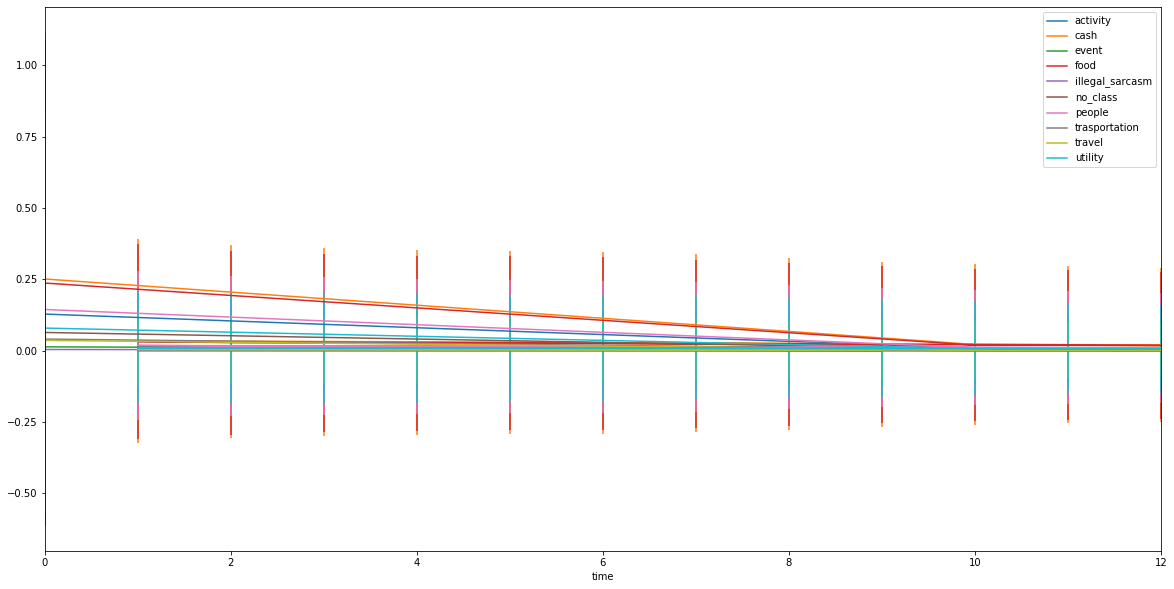

In [0]:
# after lifetime 10, the means for all categories' spendings tend to be stable and close to zero. 
fig, ax = plt.subplots(figsize=(20, 10))

for key, group in df_dynamic_summary.groupby('category'):
    group.plot('time', 'mean', yerr='2std', label=key, ax=ax) 

plt.show()

# Part 2: Social network analytics 

## Q5 Find a user’s friends and friends of friends 

In [0]:
# find user's friends
df_friends = spark.sql("select distinct user1 as user, user2 as friends \
                   from \
                    (select distinct user1, user2 from Venmo \
                    union select distinct user2, user1 from Venmo) T\
                   order by user, friends")

df_friends.createOrReplaceTempView("df_friends")
#df_friends.show()

In [0]:
# full table of user, friends, and friends of friends
# may contain some duplicates in friends and fof columns
df_edges = spark.sql("select t1.user as user, t1.friends as friends, \
                            t2.friends as fof \
                      from df_friends t1, df_friends t2 \
                      where t1.friends=t2.user and t2.friends<>t1.user \
                      order by t1.user, t1.friends, t2.friends ")

df_edges.createOrReplaceTempView("df_edges")
#df_edges.show()

In [0]:
# find user's friends of friends (remove potential duplicates in fof and friends)
df_fof = spark.sql("select t1.user, fof \
                   from df_edges t1 \
                      left join (select user, friends from df_friends) t2 \
                        on t1.user=t2.user and t1.fof=t2.friends \
                   where fof is null or t2.friends is null \
                   order by t1.user, fof ")
df_fof.createOrReplaceTempView("df_fof")
#df_fof.show()

Describe your algorithm and calculate its computational complexity. Can you do it better?

## Q6 Use the dynamic analysis from before, and calculate the social network metrics across a user’s lifetime in Venmo 

### i) Number of friends and number of friends of friends

**Number of friends**

In [0]:
# discrete lifetime and number of friends
df_dynamic_friendcnt = spark.sql("select distinct user1 as user, lifetime_indicator, \
                             count(distinct user2) as friends_cnt \
                   from \
                    (select distinct user1, user2, lifetime_indicator from lifetime_tbl \
                    union select distinct user2, user1, lifetime_indicator from lifetime_tbl) T\
                   group by user, lifetime_indicator \
                   order by user")

df_dynamic_friendcnt.createOrReplaceTempView("df_dynamic_friendcnt")
#df_dynamic_friendcnt.show()

In [0]:
# create continuous user lifetime
lst = [0,1,2,3,4,5,6,7,8,9,10,11,12]
df_usertime = df_dynamic_friendcnt.select("user").withColumn("time_lst", F.array([F.lit(x) for x in lst]))
df_usertime = df_usertime.withColumn("time_lst", F.explode(col("time_lst")))
df_usertime.createOrReplaceTempView("df_usertime")

df_lifetime_friends = spark.sql("select user, lifetime_indicator, \
                            max(ifnull(friends_cnt,0)) as friends_cnt \
                        from \
                        (select user, lifetime_indicator, friends_cnt from df_dynamic_friendcnt \
                          union \
                         select user, time_lst, null as friends_cnt from df_usertime) T \
                        group by user, lifetime_indicator \
                        order by user, lifetime_indicator")
df_lifetime_friends.createOrReplaceTempView("df_lifetime_friends")
#df_lifetime_friends.show()

In [0]:
# continuous lifetime, number of friends, cumulative number of friends
df_dynamic_cum_friends = spark.sql("select user, lifetime_indicator, friends_cnt, \
                                        (sum(friends_cnt) over (partition by user \
                                        order by lifetime_indicator)) as cum_friends \
                                    from df_lifetime_friends \
                                    order by user, lifetime_indicator ")

df_dynamic_cum_friends.createOrReplaceTempView("df_dynamic_cum_friends")
#df_dynamic_cum_friends.show()

**Number of friends of friends**

In [0]:
# number of friends of friends for each user lifetime
# step 1: find freinds and friends of friends for each user lifetime
dynamic_friends = spark.sql("select user1 as user, user2 as friends, lifetime_indicator \
                   from \
                    (select distinct user1, user2, lifetime_indicator from lifetime_tbl \
                    union \
                    select distinct user2, user1, lifetime_indicator from lifetime_tbl) T\
                   order by user, lifetime_indicator, friends")

dynamic_friends.createOrReplaceTempView("dynamic_friends")

df_dynamic_edges = spark.sql("select d1.user, d1.friends, d2.friends as fof, \
                            d1.lifetime_indicator \
                        from dynamic_friends d1, dynamic_friends d2 \
                        where d1.friends=d2.user \
                            and d1.lifetime_indicator = d2.lifetime_indicator \
                            and d2.friends<>d1.user \
                        order by d1.user, d1.lifetime_indicator")
df_dynamic_edges.createOrReplaceTempView("df_dynamic_edges")

In [0]:
# step 2: deal with situation when user's friends of friends are also in friends list 
df_dynamic_fof = spark.sql("select t1.user, fof, t1.lifetime_indicator \
                   from df_dynamic_edges t1 \
                        left join (select user, friends, \
                            lifetime_indicator from dynamic_friends) t2 \
                        on t1.user=t2.user \
                        and t1.lifetime_indicator=t2.lifetime_indicator \
                        and t1.fof=t2.friends \
                   where fof is null or t2.friends is null \
                   order by t1.user, t1.lifetime_indicator, fof")

df_dynamic_fof.createOrReplaceTempView("df_dynamic_fof")
#df_dynamic_fof.show()

In [0]:
# step 3: calculate number of fof for each lifetime
df_dynamic_fofcnt = spark.sql("select distinct user, lifetime_indicator, \
                    count(distinct fof) as fof_cnt \
                  from ( \
                      select d1.user, fof, d1.lifetime_indicator \
                      from dynamic_friends d1 left join df_dynamic_fof d2 \
                      on d1.user=d2.user \
                        and d1.lifetime_indicator=d2.lifetime_indicator) T \
                  group by user, lifetime_indicator \
                  order by user, lifetime_indicator")

df_dynamic_fofcnt.createOrReplaceTempView("df_dynamic_fofcnt")
#df_dynamic_fofcnt.show()

In [0]:
# step 4: create continuous friends of friends count
df_lifetime_fofcnt = spark.sql("select user, lifetime_indicator, \
                            max(ifnull(fof_cnt,0)) as fof_cnt \
                        from \
                        (select user, lifetime_indicator, fof_cnt from df_dynamic_fofcnt \
                          union \
                         select user, time_lst, null as fof_cnt from df_usertime) T \
                        group by user, lifetime_indicator \
                        order by user, lifetime_indicator")
df_lifetime_fofcnt.createOrReplaceTempView("df_lifetime_fofcnt")
#df_lifetime_fofcnt.show()

### ii) Clustering coefficient of a user's network

In [0]:
# step 1: calculate vertices
df_friends_vertices = spark.sql("select user, lifetime_indicator, \
                                    cum_friends*(cum_friends-1)/2 as num_vertices \
                                 from df_dynamic_cum_friends \
                                 order by user, lifetime_indicator")

df_friends_vertices.createOrReplaceTempView("df_friends_vertices")
#df_friends_vertices.show()

In [0]:
# find the first time that the two users made transactions
t1 = spark.sql("select distinct user1, min(datetime) as first_usage_date \
                from \
                    (select user1, datetime from days_lifeindicator_tbl \
                    union select user2, datetime from days_lifeindicator_tbl) T \
                group by user1 \
                order by user1")

t1.createOrReplaceTempView("t1")

t2 = spark.sql("select distinct user1, user2, datetime, lifetime_indicator \
                from (select user1, user2, datetime, lifetime_indicator \
                      from days_lifeindicator_tbl \
                      union \
                      select user2, user1, datetime, lifetime_indicator \
                      from days_lifeindicator_tbl) T \
                order by user1")

t2.createOrReplaceTempView("t2")

dy_first_meet = spark.sql("select user1, user2, min(datetime) as first_meet_date, \
                                       min(lifetime_indicator) as first_meet_lifetime, \
                                       first_usage_date \
                            from t2 join t1 using (user1) \
                            group by user1, user2, first_usage_date \
                            order by user1, min(datetime)")

dy_first_meet.createOrReplaceTempView("dy_first_meet")
#dy_first_meet.show()

In [0]:
# self join
df_triangle = spark.sql("select d1.user1 as d1_userA, d1.user2 as d2_userB, \
                          d1.first_usage_date as d1_first_usage_date, \
                          d1.first_meet_date as d1_datetime, \
                          d2.user1 as d2_userA, d2.user2 as d2_userB, \
                          d2.first_meet_date as d2_datetime,\
                          d3.user1 as d3_userA, d3.user2 as d3_userB, \
                          d3.first_meet_date as d3_datetime \
                        from dy_first_meet d1 left join dy_first_meet d2 on d1.user2=d2.user1 \
                                                          and d1.user1 <> d2.user2 \
                                left join dy_first_meet d3 on d2.user2=d3.user1 \
                                                          and d2.user1 <> d3.user2 \
                        where d1.user1=d3.user2 \
                        order by d1.user1 ")

df_triangle.createOrReplaceTempView("df_triangle")
#df_triangle.show(20)

In [0]:
df_triangle_life = spark.sql("select d1_userA, d2_userA, d3_userA, \
                                ceil(datediff(greatest(d1_datetime, d2_datetime, d3_datetime), \
                                      d1_first_usage_date)/30) as tri_lifetime \
                              from df_triangle")

df_triangle_life.createOrReplaceTempView("df_triangle_life")
#df_triangle_life.show()

In [0]:
df_triangles = spark.sql("select d1_userA as user, tri_lifetime, count(*)/2 as num_tris \
           from df_triangle_life \
           where tri_lifetime <= 12 \
           group by d1_userA, tri_lifetime \
           order by d1_userA, tri_lifetime")

df_triangles.createOrReplaceTempView("df_triangles")
#df_triangles.show()

In [0]:
df_fulllife_triangles = spark.sql("select user, tri_lifetime as lifetime, \
                                            sum(num_tris) as tot_tris \
                                   from (\
                                      select user, tri_lifetime, num_tris from df_triangles\
                                      union \
                                      select user, time_lst, 0 as num_tris from df_usertime) \
                                   group by user, tri_lifetime \
                                   order by user, tri_lifetime ")

window = Window.partitionBy("user").orderBy("lifetime")
df_fulllife_triangles = df_fulllife_triangles.withColumn("cum_tris", 
                        F.sum("tot_tris").over(window)).sort(F.col("user"), F.col("lifetime"))
df_fulllife_triangles.createOrReplaceTempView("df_fulllife_triangles")

#df_fulllife_triangles.show()

In [0]:
df_cluster = spark.sql("select t1.user, t1.lifetime, \
                              ifnull(cum_tris/num_vertices,0) as cluster_coeff \
                      from df_fulllife_triangles t1 join df_friends_vertices t2 \
                              on t1.user=t2.user and t1.lifetime = t2.lifetime_indicator \
                      order by t1.user, t1.lifetime")

df_cluster.createOrReplaceTempView("df_cluster")
#df_cluster.show()

### iii) Calculate the page rank of each user

In [0]:
import networkx as nx
G = nx.Graph()

pairs = df_friends.select("user", "friends")
nx_tuples = pairs.rdd.map(tuple).collect()
G.add_edges_from(nx_tuples)

In [0]:
pagerank = nx.pagerank_scipy(G)
dict(list(pagerank.items())[0:10])

{2: 4.157477977789461e-07,
 3: 8.653820777473779e-07,
 43: 3.2127973908043654e-06,
 52: 1.6571325641882515e-07,
 220: 1.435516964442576e-07,
 191142: 2.7629757837595304e-07,
 263437: 7.489934678145929e-07,
 567957: 8.505700929517217e-07,
 1079020: 4.2278735212380876e-07,
 1204190: 8.981909064048241e-07}

In [0]:
# covert dictionary to pyspark dateframe
df_pagerank = pd.DataFrame(pagerank.items(), columns=['user', 'pagerank'])
df_pagerank = spark.createDataFrame(df_pagerank)
df_pagerank.createOrReplaceTempView("df_pagerank")
#df_pagerank.show()

# Part 3: Predictive analytics with MLlib 

## Q7 Create dependent variable Y - the total number of transactions during her/his twelve months in Venmo

In [0]:
# calculate total number of transactions for each user on Venmo
df_y = spark.sql("select user1, count(*) as y \
                  from lifetime_tbl group by user1 \
                  order by user1")
df_y.createOrReplaceTempView("df_y")
#df_y.show()

## Q8 Create the recency and frequency variables 

In [0]:
# create dataframe with two columns: user1 and time_list (0-12)
# each user has lifetime 0 to 12
lst = [0,1,2,3,4,5,6,7,8,9,10,11,12]
df_timelst = df_y.withColumn("time_lst", F.array([F.lit(x) for x in lst]))
df_timelst = df_timelst.withColumn("time_lst", F.explode(col("time_lst")))

# summarize number of transactions and the last transaction day in each lifetime period
df_summary = spark.sql("select user1, lifetime_indicator, count(*) as freq_times, \
                              max(days) as max_days \
                        from lifetime_tbl \
                        group by user1, lifetime_indicator")

df_timelst.createOrReplaceTempView("df_timelst")
df_summary.createOrReplaceTempView("df_summary")

In [0]:
# union dataframes and remove duplicated lifetime
df_distinct_summary = spark.sql("select user1, lifetime_indicator, max(max_days) as max_days, \
                        max(freq_times) as freq_times \
                  from \
                      (select user1, lifetime_indicator, max_days, freq_times from df_summary \
                      union  \
                      select user1, time_lst, null as max_days, null as freq_times \
                      from df_timelst) T \
                  group by user1, lifetime_indicator \
                  order by user1, lifetime_indicator ")

df_distinct_summary.createOrReplaceTempView("df_distinct_summary")
#df_distinct_summary.show()

In [0]:
# calculate frequency and recency
# frequency: (ACCUMULATED) 
    #how often a user uses Venmo in a month. It is standardized and equals to (number of transactions/30)
# recency: the last time a user was active
    #if a user has used Venmo twice during her first month in Venmo with the second time being on day x, 
    #then her recency in month 1 is “30-x”

df_x = spark.sql("select user1, lifetime_indicator, max_days, \
                    ifnull(freq_times, 0)/30 as frequency, \
                    sum(ifnull(freq_times, 0)) \
                    over (partition by user1 \
                    order by lifetime_indicator asc \
                    range between unbounded preceding and current row) as cum_freq, \
                (lifetime_indicator*30-max(max_days) \
                    over(partition by user1 \
                         order by lifetime_indicator asc \
                         range between unbounded preceding and current row)) as recency \
              from df_distinct_summary \
              order by user1, lifetime_indicator")
df_x.createOrReplaceTempView("df_x")

# add cumulative frequency
df_x = spark.sql("select user1, lifetime_indicator, max_days,\
                    frequency, \
                    cum_freq/(30*if(lifetime_indicator=0, 1, lifetime_indicator)) as cum_frequency, \
                    recency \
                  from df_x \
              order by user1, lifetime_indicator")

df_x.createOrReplaceTempView("df_x")
#df_x.show(60)

## Q9 For each user’s lifetime point, regress recency and frequency on ​Y. Plot the MSE for each lifetime point 

In [0]:
# join tables to combine user lifetime, frequency, recency and number of total transactions (y)
df_input = spark.sql("select user1, lifetime_indicator, frequency, cum_frequency, \
                              recency, y \
                  from df_x join df_y using (user1) \
                  order by user1, lifetime_indicator")
df_input.createOrReplaceTempView("df_input")
#df_input.show()

In [0]:
df_input_time0 = spark.sql("select * from df_input where lifetime_indicator=0 ")
df_input_time1 = spark.sql("select * from df_input where lifetime_indicator=1 ")
df_input_time2 = spark.sql("select * from df_input where lifetime_indicator=2 ")
df_input_time3 = spark.sql("select * from df_input where lifetime_indicator=3 ")
df_input_time4 = spark.sql("select * from df_input where lifetime_indicator=4 ")
df_input_time5 = spark.sql("select * from df_input where lifetime_indicator=5 ")
df_input_time6 = spark.sql("select * from df_input where lifetime_indicator=6 ")
df_input_time7 = spark.sql("select * from df_input where lifetime_indicator=7 ")
df_input_time8 = spark.sql("select * from df_input where lifetime_indicator=8 ")
df_input_time9 = spark.sql("select * from df_input where lifetime_indicator=9 ")
df_input_time10 = spark.sql("select * from df_input where lifetime_indicator=10 ")
df_input_time11 = spark.sql("select * from df_input where lifetime_indicator=11 ")
df_input_time12 = spark.sql("select * from df_input where lifetime_indicator=12 ")

In [0]:
def lifetimeMSE(inputdata):
    Assembler = VectorAssembler(inputCols = ['lifetime_indicator', 'frequency', 
                                             'cum_frequency','recency'], 
                                outputCol ='features')
    output = Assembler.transform(inputdata)
    finalData = output.select('features','y')
    trainData, testData = finalData.randomSplit([0.7, 0.3], seed=1)
    lrModel = LinearRegression(labelCol ='y', featuresCol='features')
    lrEstimator = lrModel.fit(trainData)
    testResults = lrEstimator.evaluate(testData)
    rmse = testResults.rootMeanSquaredError
    mse = rmse**2
    return mse

In [0]:
MSE_time0 = lifetimeMSE(df_input_time0)
print(MSE_time0)
MSE_time1 = lifetimeMSE(df_input_time1)
print(MSE_time1)
MSE_time2 = lifetimeMSE(df_input_time2)
print(MSE_time2)
MSE_time3 = lifetimeMSE(df_input_time3)
print(MSE_time3)
MSE_time4 = lifetimeMSE(df_input_time4)
print(MSE_time4)
MSE_time5 = lifetimeMSE(df_input_time5)
print(MSE_time5)

7.652437351481585
6.691173069837235
6.446252930703639
5.932649981257501
5.4084412991178805
5.1461627088341375


In [0]:
MSE_time6 = lifetimeMSE(df_input_time6)
MSE_time7 = lifetimeMSE(df_input_time7)
MSE_time8 = lifetimeMSE(df_input_time8)
MSE_time9 = lifetimeMSE(df_input_time9)
MSE_time10 = lifetimeMSE(df_input_time10)
MSE_time11 = lifetimeMSE(df_input_time11)
print(MSE_time11)
MSE_time12 = lifetimeMSE(df_input_time12)
print(MSE_time12)

MSE = []
MSE.extend([MSE_time0, MSE_time1, MSE_time2, MSE_time3, MSE_time4, MSE_time5, MSE_time6, 
            MSE_time7, MSE_time8, MSE_time9, MSE_time10, MSE_time11, MSE_time12])
MSE

3.9360616020741523
4.0460952793410225


[7.652437351481585,
 6.691173069837235,
 6.446252930703639,
 5.932649981257501,
 5.4084412991178805,
 5.1461627088341375,
 4.598004098833828,
 4.474719220817289,
 4.212880388012137,
 4.169087571580209,
 4.085268865599057,
 3.9360616020741523,
 4.0460952793410225]

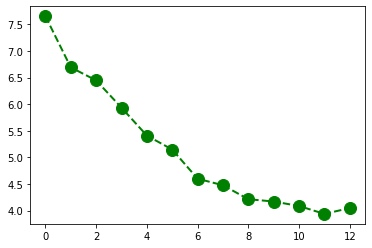

In [0]:
Lifetime = [0,1,2,3,4,5,6,7,8,9,10,11,12]
plt.plot(Lifetime, MSE, 'go--', linewidth=2, markersize=12) 

## Q10 For each user’s lifetime point, regress recency, frequency AND her spending behavior profile on Y. Plot the MSE for each lifetime point like above

In [0]:
df_dycfull_profile = spark.sql("select user1, lifetime_indicator, \
                    max(frequency) as frequency, \
                    sum(max(frequency)) \
                      over (partition by user1 \
                      order by lifetime_indicator asc \
                      range between unbounded preceding and current row) as cum_freq, \
                    max(recency) as recency, max(ifnull(people,0)) as people, \
                    max(ifnull(food,0)) as food, max(ifnull(activity,0)) as activity, \
                    max(ifnull(event,0)) as event, max(ifnull(travel,0)) as travel, \
                    max(ifnull(cash,0)) as cash, max(ifnull(utility,0)) as utility, \
                    max(ifnull(trasportation,0)) as trasportation, \
                    max(ifnull(illegal_sarcasm,0)) as illegal_sarcasm, \
                    max(ifnull(no_class,0)) as no_class \
                  from \
                      (select *, null as frequency, null as recency from dynamic_profile \
                      union  \
                      select user1, lifetime_indicator, \
                          null,null,null,null,null,null,null,null,null,null, \
                          frequency, recency from df_input) T \
                  group by user1, lifetime_indicator \
                  order by user1, lifetime_indicator  ")

df_dycfull_profile.createOrReplaceTempView("df_dycfull_profile")

# add cumulative frequency
df_dycfull_profile = spark.sql("select user1, lifetime_indicator, frequency, \
                    cum_freq/(30*if(lifetime_indicator=0, 1, lifetime_indicator)) as cum_frequency,\
                    recency, people, food, activity, event, travel, cash, utility, \
                    trasportation, illegal_sarcasm, no_class \
                  from df_dycfull_profile \
                  order by user1, lifetime_indicator ")

df_dycfull_profile.createOrReplaceTempView("df_dycfull_profile")
df_dycfull_profile.show()

+-----+------------------+-------------------+--------------------+-------+------+----+--------+-----+------+----+-------+-------------+---------------+--------+
|user1|lifetime_indicator|          frequency|       cum_frequency|recency|people|food|activity|event|travel|cash|utility|trasportation|illegal_sarcasm|no_class|
+-----+------------------+-------------------+--------------------+-------+------+----+--------+-----+------+----+-------+-------------+---------------+--------+
|    2|                 0|0.03333333333333333|0.001111111111111...|      0|   0.0| 1.0|     0.0|  0.0|   0.0| 0.0|    0.0|          0.0|            0.0|     0.0|
|    2|                 1|                0.0|0.001111111111111...|     30|   0.0| 0.0|     0.0|  0.0|   0.0| 0.0|    0.0|          0.0|            0.0|     0.0|
|    2|                 2|                0.0|5.555555555555556E-4|     60|   0.0| 0.0|     0.0|  0.0|   0.0| 0.0|    0.0|          0.0|            0.0|     0.0|
|    2|                 3|  

In [0]:
df_dynamic_input = spark.sql("select * \
                  from df_dycfull_profile join df_y using (user1) \
                  order by user1, lifetime_indicator")

df_dynamic_input.createOrReplaceTempView("df_dynamic_input")

In [0]:
df_dynamic_input_time0 = spark.sql("select * from df_dynamic_input where lifetime_indicator=0 ")
df_dynamic_input_time1 = spark.sql("select * from df_dynamic_input where lifetime_indicator=1 ")
df_dynamic_input_time2 = spark.sql("select * from df_dynamic_input where lifetime_indicator=2 ")
df_dynamic_input_time3 = spark.sql("select * from df_dynamic_input where lifetime_indicator=3 ")
df_dynamic_input_time4 = spark.sql("select * from df_dynamic_input where lifetime_indicator=4 ")
df_dynamic_input_time5 = spark.sql("select * from df_dynamic_input where lifetime_indicator=5 ")
df_dynamic_input_time6 = spark.sql("select * from df_dynamic_input where lifetime_indicator=6 ")
df_dynamic_input_time7 = spark.sql("select * from df_dynamic_input where lifetime_indicator=7 ")
df_dynamic_input_time8 = spark.sql("select * from df_dynamic_input where lifetime_indicator=8 ")
df_dynamic_input_time9 = spark.sql("select * from df_dynamic_input where lifetime_indicator=9 ")
df_dynamic_input_time10 = spark.sql("select * from df_dynamic_input where lifetime_indicator=10 ")
df_dynamic_input_time11 = spark.sql("select * from df_dynamic_input where lifetime_indicator=11 ")
df_dynamic_input_time12 = spark.sql("select * from df_dynamic_input where lifetime_indicator=12 ")

In [0]:
def dynamicMSE(inputdata):
    Assembler = VectorAssembler(inputCols = ['lifetime_indicator', 'frequency', 
                            'cum_frequency','recency', 'people', 'food', 
                            'activity', 'event', 'travel', 'cash',
                            'utility', 'trasportation', 'illegal_sarcasm', 'no_class'], 
                                outputCol ='features')
    output = Assembler.transform(inputdata)
    finalData = output.select('features','y')
    trainData, testData = finalData.randomSplit([0.7, 0.3], seed=1)
    lrModel = LinearRegression(labelCol ='y', featuresCol='features')
    lrEstimator = lrModel.fit(trainData)
    testResults = lrEstimator.evaluate(testData)
    rmse = testResults.rootMeanSquaredError
    mse = rmse**2
    return mse

In [0]:
dynamic_MSE_time0 = dynamicMSE(df_dynamic_input_time0)
dynamic_MSE_time1 = dynamicMSE(df_dynamic_input_time1)
dynamic_MSE_time2 = dynamicMSE(df_dynamic_input_time2)
dynamic_MSE_time3 = dynamicMSE(df_dynamic_input_time3)
dynamic_MSE_time4 = dynamicMSE(df_dynamic_input_time4)
dynamic_MSE_time5 = dynamicMSE(df_dynamic_input_time5)
dynamic_MSE_time6 = dynamicMSE(df_dynamic_input_time6)
dynamic_MSE_time7 = dynamicMSE(df_dynamic_input_time7)
dynamic_MSE_time8 = dynamicMSE(df_dynamic_input_time8)
print(dynamic_MSE_time8)
dynamic_MSE_time9 = dynamicMSE(df_dynamic_input_time9)
print(dynamic_MSE_time9)
dynamic_MSE_time10 = dynamicMSE(df_dynamic_input_time10)
print(dynamic_MSE_time10)
dynamic_MSE_time11 = dynamicMSE(df_dynamic_input_time11)
print(dynamic_MSE_time11)
dynamic_MSE_time12 = dynamicMSE(df_dynamic_input_time12)
print(dynamic_MSE_time12)

dynamic_MSE = []
dynamic_MSE.extend([dynamic_MSE_time0, dynamic_MSE_time1, dynamic_MSE_time2, 
                    dynamic_MSE_time3, dynamic_MSE_time4, dynamic_MSE_time5, 
                    dynamic_MSE_time6, dynamic_MSE_time7, dynamic_MSE_time8, 
                    dynamic_MSE_time9, dynamic_MSE_time10, dynamic_MSE_time11, 
                    dynamic_MSE_time12])
dynamic_MSE

4.133952392398463
3.9143145286213525
3.9224805975974513
3.9707377366893613
3.9371401169889655


[7.77942060977086,
 6.811480563454807,
 6.419777085708892,
 5.822322144035492,
 5.196309794718509,
 4.881407957874058,
 4.443287721307322,
 4.318292191885376,
 4.133952392398463,
 3.9143145286213525,
 3.9224805975974513,
 3.9707377366893613,
 3.9371401169889655]

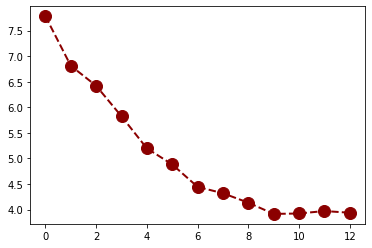

In [0]:
Lifetime = [0,1,2,3,4,5,6,7,8,9,10,11,12]
plt.plot(Lifetime, dynamic_MSE, 'b--o', color='darkred', linewidth=2, markersize=12) 

## Q11 For each user’s lifetime point, regress her social network metrics on Y. Plot the MSE for each lifetime point like above

In [0]:
# combine all social network mertics from Question 6 
df_social_network = spark.sql("select t1.user, t1.lifetime_indicator, \
                          friends_cnt, fof_cnt, cluster_coeff \
                    from df_lifetime_friends t1 \
                          join df_lifetime_fofcnt t2 on t1.user=t2.user \
                              and t1.lifetime_indicator=t2.lifetime_indicator \
                          join df_cluster t3 on t1.user=t3.user \
                              and t1.lifetime_indicator=t3.lifetime \
                    order by t1.user, t1.lifetime_indicator")

df_social_network.createOrReplaceTempView("df_social_network")
#df_social_network.show()

In [0]:
# create input metric by combining social network metric and dependent variable y 
df_sn_input = spark.sql("select t1.user, t1.lifetime_indicator, friends_cnt, \
                                fof_cnt, cluster_coeff, pagerank, y \
                         from df_social_network t1 join df_y t2 \
                                on t1.user=t2.user1\
                              join df_pagerank t3 on t1.user=t3.user \
                         order by t1.user, t1.lifetime_indicator")

df_sn_input.createOrReplaceTempView("df_sn_input")
#df_sn_input.show()

In [0]:
df_sn_input_time0 = spark.sql("select * from df_sn_input where lifetime_indicator=0 ")
df_sn_input_time1 = spark.sql("select * from df_sn_input where lifetime_indicator=1 ")
df_sn_input_time2 = spark.sql("select * from df_sn_input where lifetime_indicator=2 ")
df_sn_input_time3 = spark.sql("select * from df_sn_input where lifetime_indicator=3 ")
df_sn_input_time4 = spark.sql("select * from df_sn_input where lifetime_indicator=4 ")
df_sn_input_time5 = spark.sql("select * from df_sn_input where lifetime_indicator=5 ")
df_sn_input_time6 = spark.sql("select * from df_sn_input where lifetime_indicator=6 ")
df_sn_input_time7 = spark.sql("select * from df_sn_input where lifetime_indicator=7 ")
df_sn_input_time8 = spark.sql("select * from df_sn_input where lifetime_indicator=8 ")
df_sn_input_time9 = spark.sql("select * from df_sn_input where lifetime_indicator=9 ")
df_sn_input_time10 = spark.sql("select * from df_sn_input where lifetime_indicator=10 ")
df_sn_input_time11 = spark.sql("select * from df_sn_input where lifetime_indicator=11 ")
df_sn_input_time12 = spark.sql("select * from df_sn_input where lifetime_indicator=12 ")

In [0]:
def socialnetworkMSE(inputdata):
    Assembler = VectorAssembler(inputCols = ['lifetime_indicator', 'friends_cnt', 
                                'fof_cnt', 'cluster_coeff', "pagerank"], 
                                outputCol ='features')
    output = Assembler.transform(inputdata)
    finalData = output.select('features','y')
    trainData, testData = finalData.randomSplit([0.7, 0.3], seed=1)
    lrModel = LinearRegression(labelCol ='y', featuresCol='features')
    lrEstimator = lrModel.fit(trainData)
    testResults = lrEstimator.evaluate(testData)
    rmse = testResults.rootMeanSquaredError
    mse = rmse**2
    return mse

In [0]:
# sn_MSE_time0 = socialnetworkMSE(df_sn_input_time0)
# print(sn_MSE_time0)
# sn_MSE_time1 = socialnetworkMSE(df_sn_input_time1)
# print(sn_MSE_time1)
# sn_MSE_time2 = socialnetworkMSE(df_sn_input_time2)
# print(sn_MSE_time2)
# sn_MSE_time3 = socialnetworkMSE(df_sn_input_time3)
# print(sn_MSE_time3)
# sn_MSE_time4 = socialnetworkMSE(df_sn_input_time4)
# print(sn_MSE_time4)
# sn_MSE_time5 = socialnetworkMSE(df_sn_input_time5)
# print(sn_MSE_time5)
# sn_MSE_time6 = socialnetworkMSE(df_sn_input_time6)
# print(sn_MSE_time6)
# sn_MSE_time7 = socialnetworkMSE(df_sn_input_time7)
# print(sn_MSE_time7)
# sn_MSE_time8 = socialnetworkMSE(df_sn_input_time8)
# print(sn_MSE_time8)
# sn_MSE_time9 = socialnetworkMSE(df_sn_input_time9)
# print(sn_MSE_time9)
# sn_MSE_time10 = socialnetworkMSE(df_sn_input_time10)
# print(sn_MSE_time10)
# sn_MSE_time11 = socialnetworkMSE(df_sn_input_time11)
# print(sn_MSE_time11)
# sn_MSE_time12 = socialnetworkMSE(df_sn_input_time12)
# print(sn_MSE_time12)

sn_MSE = []
sn_MSE.extend([sn_MSE_time0, sn_MSE_time1, sn_MSE_time2, sn_MSE_time3, 
            sn_MSE_time4, sn_MSE_time5, sn_MSE_time6, sn_MSE_time7, 
            sn_MSE_time8, sn_MSE_time9, sn_MSE_time10, sn_MSE_time11, sn_MSE_time12])
sn_MSE

In [0]:
sn_MSE_time0=5.058206013156707
sn_MSE_time1=4.5115567708412305

sn_MSE_time5=4.312948761244053

sn_MSE_time9=4.484058952467369
sn_MSE_time12=4.589418594272139

In [0]:
Lifetime = [0,1,2,3,4,5,6,7,8,9,10,11,12]
plt.plot(Lifetime, sn_MSE, 'go--', color='blue', linewidth=2, markersize=12) 

## Q12 For each user’s lifetime point, regress her social network metrics and the spending behavior of her social network on Y. Plot the MSE for each lifetime point like above

### Step 1: Create spending profile of user's social network

In [0]:
# fill in user lifetime as continuous intervals
df_user_fulllife = spark.sql("select user1 as user, lifetime_indicator, \
                                     max(first_datetime) as user_first_datetime\
                              from (select user1, lifetime_indicator, \
                                            datetime as first_datetime\
                                    from days_lifeindicator_tbl \
                                    where lifetime_indicator = 0 \
                                    union \
                                    select user1, time_lst, null as datetime \
                                    from df_timelst) \
                              group by user1, lifetime_indicator \
                              order by user1, lifetime_indicator ")

w = Window.partitionBy("user").orderBy("lifetime_indicator")
df_user_fulllife = df_user_fulllife.withColumn("first_date", 
              F.min("user_first_datetime").over(w)).sort(F.col("user"), F.col("lifetime_indicator"))

df_user_fulllife.createOrReplaceTempView("df_user_fulllife")
#df_user_fulllife.show()

In [0]:
# fill in null datetime in continuous lifetime intervals with aggregated months since the first transaction

df_user_continuous_lastdate = spark.sql("select user, lifetime_indicator, \
          case when lifetime_indicator=1 then (first_date + interval 1 month) \
               when lifetime_indicator=2 then (first_date + interval 2 month) \
               when lifetime_indicator=3 then (first_date + interval 3 month) \
               when lifetime_indicator=4 then (first_date + interval 4 month) \
               when lifetime_indicator=5 then (first_date + interval 5 month) \
               when lifetime_indicator=6 then (first_date + interval 6 month) \
               when lifetime_indicator=7 then (first_date + interval 7 month) \
               when lifetime_indicator=8 then (first_date + interval 8 month) \
               when lifetime_indicator=9 then (first_date + interval 9 month) \
               when lifetime_indicator=10 then (first_date + interval 10 month) \
               when lifetime_indicator=11 then (first_date + interval 11 month) \
               when lifetime_indicator=12 then (first_date + interval 12 month) \
                else first_date \
                end as user_last_datetime \
          from df_user_fulllife \
          group by user, lifetime_indicator, first_date \
          order by user, lifetime_indicator ")

df_user_continuous_lastdate.createOrReplaceTempView("df_user_continuous_lastdate")
#df_user_continuous_lastdate.show()

In [0]:
# pair user and their friends in each continuous lifetime
df_user_friends_fulllife = spark.sql("select user1 as user, max(user2) as friends, \
                                            lifetime_indicator\
                                      from (select distinct user1, user2, lifetime_indicator \
                                            from lifetime_tbl \
                                            union \
                                            select distinct user2, user1, lifetime_indicator \
                                            from lifetime_tbl \
                                            union \
                                            select user, null as user2, time_lst \
                                            from df_usertime) T \
                                      group by user1, lifetime_indicator \
                                      order by user1, lifetime_indicator")

df_user_friends_fulllife.createOrReplaceTempView("df_user_friends_fulllife")
#df_user_friends_fulllife.show()

In [0]:
# create user profile：map user, user's continuous lifetime, their friends 
#and user's last possible transaction datetime per lifetime period
df_user = spark.sql("select t1.user, t1.lifetime_indicator, friends, user_last_datetime\
                      from df_user_continuous_lastdate t1 join df_user_friends_fulllife t2 \
                          on t1.user=t2.user \
                          and t1.lifetime_indicator=t2.lifetime_indicator \
                      order by t1.user, t1.lifetime_indicator")

df_user = df_user.distinct().sort(col("user"), col("lifetime_indicator"))
df_user.createOrReplaceTempView("df_user")
#df_user.show()

In [0]:
# create friends profile: map friends' ids, friends_datetime, 
#friends spending class and link to user lifetime
df_friends_profile = spark.sql("select t1.user1 as friends, datetime as friends_datetime, \
                                       class as friends_class, \
                                       t2.lifetime_indicator as user_lifetime \
                                from (select user1, lifetime_indicator, datetime, class\
                                    from days_lifeindicator_tbl \
                                    union \
                                    select user1, time_lst, null as datetime, null as class \
                                    from df_timelst) t1 join df_user_friends_fulllife t2 \
                                    on t1.user1=t2.friends \
                                    and t1.lifetime_indicator = t2.lifetime_indicator ")

df_friends_profile.distinct().sort(col("friends"), col("user_lifetime"))
df_friends_profile.createOrReplaceTempView("df_friends_profile")

In [0]:
df_user_friends_datetime_compare = spark.sql("select user, lifetime_indicator, t1.friends, \
                                          user_last_datetime, friends_datetime, friends_class\
                                      from df_user t1 join df_friends_profile t2 \
                                          on t1.friends=t2.friends \
                                          and t1.lifetime_indicator=t2.user_lifetime \
                                      order by user, lifetime_indicator, t1.friends")

df_user_friends_datetime_compare.select("*").distinct().sort(col("user"), col("user_lifetime"))
df_user_friends_datetime_compare.createOrReplaceTempView("df_user_friends_datetime_compare")
#df_user_friends_datetime_compare.show()

In [0]:
df_user_friends_life = spark.sql("select *, \
              if(user_last_datetime>friends_datetime or friends_datetime is not null, \
                   lifetime_indicator, -1) as friends_lifetime\
           from df_user_friends_datetime_compare \
           order by user, lifetime_indicator ")

user_friends_spending_tbl = df_user_friends_life.filter("friends_lifetime != -1 ").distinct().sort("user")
user_friends_spending_tbl.createOrReplaceTempView("user_friends_spending_tbl")
#user_friends_spending_tbl.show()

In [0]:
social_network_spendings_tbl = spark.sql("select user, lifetime_indicator, friends_class, \
                              round(count(*)/sum(count(*)) \
                                over (partition by user, lifetime_indicator), 2) as sns_ratio \
                            from user_friends_spending_tbl \
                            group by user, lifetime_indicator, friends_class \
                            order by user")

social_network_spendings_tbl.createOrReplaceTempView("social_network_spendings_tbl")
#social_network_spendings_tbl.show()

### Step 2 Prepare input for regression

In [0]:
df_sns_input = spark.sql("select t1.user, t1.lifetime_indicator, friends_cnt, \
                                fof_cnt, cluster_coeff, pagerank, \
                                friends_class,sns_ratio, y \
                         from df_sn_input t1 join social_network_spendings_tbl t2 \
                                on t1.user=t2.user \
                         order by t1.user, t1.lifetime_indicator")

df_sns_input.createOrReplaceTempView("df_sns_input")

### Step 3 Regression

In [0]:
#df_sn_spendings_input_time0 = spark.sql("select * from df_sns_input where lifetime_indicator=0 ")
#df_sn_spendings_input_time1 = spark.sql("select * from df_sns_input where lifetime_indicator=1 ")
#df_sn_spendings_input_time2 = spark.sql("select * from df_sns_input where lifetime_indicator=2 ")
#df_sn_spendings_input_time3 = spark.sql("select * from df_sns_input where lifetime_indicator=3 ")
#df_sn_spendings_input_time4 = spark.sql("select * from df_sns_input where lifetime_indicator=4 ")
#df_sn_spendings_input_time5 = spark.sql("select * from df_sns_input where lifetime_indicator=5 ")
#df_sn_spendings_input_time6 = spark.sql("select * from df_sns_input where lifetime_indicator=6 ")
#df_sn_spendings_input_time7 = spark.sql("select * from df_sns_input where lifetime_indicator=7 ")
#df_sn_spendings_input_time8 = spark.sql("select * from df_sns_input where lifetime_indicator=8 ")
#df_sn_spendings_input_time9 = spark.sql("select * from df_sns_input where lifetime_indicator=9 ")
#df_sn_spendings_input_time10 = spark.sql("select * from df_sns_input where lifetime_indicator=10 ")
#df_sn_spendings_input_time11 = spark.sql("select * from df_sns_input where lifetime_indicator=11 ")
df_sn_spendings_input_time12 = spark.sql("select * from df_sns_input where lifetime_indicator=12 ")

In [0]:
def snSpendingsMSE(inputdata):
    ClassIndexer = StringIndexer(inputCol='friends_class', outputCol ="FridensClassIndexer")
    ClassEncoder = OneHotEncoder(inputCol='FridensClassIndexer', outputCol="ClassDummies")
    pipeline = Pipeline(stages=[ClassIndexer, ClassEncoder])
    NewOutput = pipeline.fit(inputdata).transform(inputdata)
    Assembler = VectorAssembler(inputCols = ['lifetime_indicator', 'friends_cnt', 
                                'fof_cnt', 'cluster_coeff', "pagerank", 
                                "ClassDummies", "sns_ratio"], 
                                outputCol ='features')
    output = Assembler.transform(NewOutput)
    finalData = output.select('features','y')
    trainData, testData = finalData.randomSplit([0.7, 0.3], seed=1)
    lrModel = LinearRegression(labelCol ='y', featuresCol='features')
    lrEstimator = lrModel.fit(trainData)
    testResults = lrEstimator.evaluate(testData)
    rmse = testResults.rootMeanSquaredError
    mse = rmse**2
    return mse

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression 
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
ClassIndexer = StringIndexer(inputCol='friends_class', outputCol ="FridensClassIndexer")
ClassEncoder = OneHotEncoder(inputCol='FridensClassIndexer', outputCol="ClassDummies")
pipeline = Pipeline(stages=[ClassIndexer, ClassEncoder])
NewOutput = pipeline.fit(df_sn_spendings_input_time12).transform(df_sn_spendings_input_time12)
Assembler = VectorAssembler(inputCols = ['lifetime_indicator', 'friends_cnt', 
                                'fof_cnt', 'cluster_coeff', "pagerank", 
                                "ClassDummies", "sns_ratio"], 
                                outputCol ='features')
output = Assembler.transform(NewOutput)
finalData = output.select('features','y')
trainData, testData = finalData.randomSplit([0.7, 0.3], seed=1)
lrModel = LinearRegression(labelCol ='y', featuresCol='features')
lrEstimator = lrModel.fit(trainData)
testResults = lrEstimator.evaluate(testData)
rmse = testResults.rootMeanSquaredError
mse = rmse**2
print('Coefficients'+ str(lrEstimator.coefficients))
print('MSE' + str(mse))

Coefficients[0.0,1.5891787695955821,0.27128918512392963,0.6323409856752339,2127228.00256874,0.1823924784474299,0.13386987548782533,0.1727047953665476,0.1470188436972126,0.16394963961439465,-0.0029635231000119085,0.1377200971091724,0.17078122019112804,0.0999276864762198,-0.6616702528844915]
MSE8.408408230851474


In [0]:
sns_MSE_time12 = snSpendingsMSE(df_sn_spendings_input_time12)
print(sns_MSE_time12)

#sns_MSE = []
#sns_MSE.extend([sns_MSE_time0, sns_MSE_time1, sns_MSE_time2, sns_MSE_time3, 
#            sns_MSE_time4, sns_MSE_time5, sns_MSE_time6, sns_MSE_time7, 
#            sns_MSE_time8, sns_MSE_time9, sns_MSE_time10, sns_MSE_time11, sns_MSE_time12])
#sns_MSE

9.490423097110567


In [0]:
coeff = str(lrEstimator.coefficients)
type(coeff)

str

In [0]:
Lifetime = [0,1,2,3,4,5,6,7,8,9,10,11,12]
plt.plot(Lifetime, sns_MSE, 'go--', color='orange', linewidth=2, markersize=12) 